<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-a-Restricted-Boltzmann-Machine" data-toc-modified-id="Training-a-Restricted-Boltzmann-Machine-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Training a Restricted Boltzmann Machine</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Implement-the-sigmoid-function-(10-P)" data-toc-modified-id="Implement-the-sigmoid-function-(10-P)-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Implement the sigmoid function (10 P)</a></span></li><li><span><a href="#Implement-the-alternate-Gibbs-sampler-(10-P)" data-toc-modified-id="Implement-the-alternate-Gibbs-sampler-(10-P)-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Implement the alternate Gibbs sampler (10 P)</a></span></li><li><span><a href="#Implementing-the-gradient-(10-P)" data-toc-modified-id="Implementing-the-gradient-(10-P)-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Implementing the gradient (10 P)</a></span></li><li><span><a href="#Implementing-gradient-ascent-(10-P)" data-toc-modified-id="Implementing-gradient-ascent-(10-P)-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Implementing gradient ascent (10 P)</a></span></li><li><span><a href="#Training-and-Inspecting-the-RBM" data-toc-modified-id="Training-and-Inspecting-the-RBM-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Training and Inspecting the RBM</a></span></li></ul></li></ul></li></ul></div>

# Training a Restricted Boltzmann Machine

In this exercise, we implement and train an RBM to model the distribution of MNIST digits 3. The following code loads some libraries, extracts the MNIST digits 3, and converts them to binary vectors.

In [22]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy,numpy.random

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = (mnist.data[mnist.target=='3']>127.5)*1.0

X.shape, X.min(), X.max() 


((7141, 784), 0.0, 1.0)

The RBM learning algorithm consists of several parts, which we will implement one after the other.

### Implement the sigmoid function (10 P)

Implement a function that receives a vector of values and applies the sigmoid function

$$
\text{sigm}(t) = \frac{\exp(t)}{1+\exp(t)}
$$

element-wise to that vector. Note that a naive implementation the function is numerically instable. Instability can be avoided by using the hyperbolic tangent and applying some rescaling/offseting so that it matches the sigmoid. Alternatively, one can distinguish between large values of $t$ and small values of $t$ and apply a different treatment to these two cases. In any case, your implementation should be numerically stable, and fast (i.e. use vector operations instead of loops).

In [23]:
def sigm(z):

    return numpy.tanh(0.5*z)*0.5+0.5 # tanh is for hyperbolic tangent

Your implementation can be tested with the code below

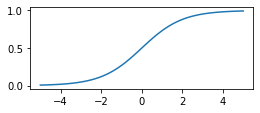

In [24]:
z = numpy.linspace(-5,5,100)
plt.figure(figsize=(4,1.5)); plt.plot(z,sigm(z)); plt.show()

Before implementing the RBM, we need a data structure to store its parameters. Here, we use a dictionary containing the weights and bias given as numpy arrays. Our RBM has 784 input dimensions (the number of pixels in a MNIST digit), and 100 hidden units (i.e. 100 experts).

In [25]:
d = 784 # input dimensions
H = 100 # hidden units

rbm = {
    'W': numpy.random.normal(0,0.1,[d,H]),
    'b': numpy.zeros([H]),
}

The initial weights of the RBM are set at random in order to break symmetries.


### Implement the alternate Gibbs sampler (10 P)

We would like to implement a function that performs alternate Gibbs sampling to generate samples from the distribution modeled by the RBM. Recall: Each unit of the RBM is sampled according to a Bernoulli distribution of some parameter p depending on the other units:

\begin{align*}
\forall_{j=1}^H:~h_j &\sim \text{Bernoulli}(p=\text{sigm}(\boldsymbol{x}^\top \boldsymbol{w}_j+b_j))\\
\forall_{i=1}^d:~x_i &\sim \text{Bernoulli}(p=\text{sigm}(\boldsymbol{h}^\top \boldsymbol{w}_i))\\
\end{align*}

where $\boldsymbol{w}_i$ denotes the vector of weights that connect to input feature $i$.

*Hint: drawing from a Bernoulli distribution is equivalent to drawing from a binomial distribution with `n=1`. Hence, you can make use of the function `numpy.random.binomial`, which supports vector operation by admits a vector of probabilities as input. Here is an example:*

In [26]:
numpy.random.binomial(1,numpy.linspace(0,1,22))

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

**Task: Implement the function below that receives as input a variable `rbm` representing the dictionary containing the RBM parameters, a data point `x` given as a numpy array of shape `(784,)`, and an integer `k` corresponding to the number of alternate Gibbs sampling steps it should perform. Your function should return a sample of same shape as your data point.

*Hint: You can use matrix-vector multiplication to compute several probabilities values in parallel.*

In [27]:
#  ERROR

def gibbs(rbm,x,k):
    
    W,b = rbm['W'],rbm['b']
    
    xm = x
    
    for _ in range(k):
        ph = sigm(xm.dot(W)+b)
        hm = numpy.random.binomial(1,ph)
        px = sigm(hm.dot(W.T))
        xm = numpy.random.binomial(1,px)
        
    return xm

The gibbs sampler you have implemented can be tested on some MNIST digit.

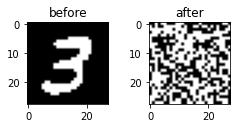

In [28]:
xm = gibbs(rbm,X[0],3)

plt.figure(figsize=(4,1.5))
ax = plt.subplot(1,2,1); 
ax.set_title('before');
ax.imshow(X[0].reshape(28,28),cmap='gray')
ax = plt.subplot(1,2,2);
ax.set_title('after');
ax.imshow(xm.reshape(28,28),cmap='gray')
plt.show()

The sample looks like random noise. This is because the RBM has not been trained yet.

### Implementing the gradient (10 P)


Now we will create a function that implements the gradient of the log-likelihood the RBM associates to a given data point $\boldsymbol{x}$. Recall: The components of the gradient are given by:

\begin{align*}
\nabla_{\boldsymbol{w}_j} \log p(\boldsymbol{x}|\theta) &= \boldsymbol{x} \cdot \text{sigm}(\boldsymbol{w}_j^\top \boldsymbol{x} + b_j) - \mathbb{E}_{p(\boldsymbol{x}|\theta)}[\boldsymbol{x} \cdot \text{sigm}(\boldsymbol{w}_j^\top \boldsymbol{x} + b_j)]\\
\nabla_{b_j} \log p(\boldsymbol{x}|\theta) &= \text{sigm}(\boldsymbol{w}_j^\top \boldsymbol{x} + b_j) - \mathbb{E}_{p(\boldsymbol{x}|\theta)}[\text{sigm}(\boldsymbol{w}_j^\top \boldsymbol{x} + b_j)] 
\end{align*}

The rightmost term will be approximated using CD-k, i.e. we start from the data point and apply k steps of Gibbs samping using the function implemented above. We set the number of steps to k=3.

**Task: Implement a function that computes the proposed approximation of the gradient for a given data point $\boldsymbol{x}$ given as an array of shape `(784,)`. Your function should return a tuple `(dW,db)` where `dW` and `db` are arrays of same size as the parameters `W` and `b` of the RBM, but containing the approximated gradients.**

In [29]:
def gradient(rbm,x):
    
    W,b = rbm['W'],rbm['b']

    h = sigm(x.dot(W)+b)
    xm = gibbs(rbm,x,3)
    hm = sigm(xm.dot(W)+b)
        
    return numpy.outer(x,h) - numpy.outer(xm,hm),h-hm

### Implementing gradient ascent (10 P)

We now would like to learn the parameters of the RBM by performing a gradient ascent procedure. The function to implement should loop for the number of iterations `nbit` specified as argument, at each iteration pick one data point at random, compute the gradient using the method implemented above, and preform the update step using the learning rate `lr` specified as argument. Recall: the update step is given by:

\begin{align*}
\boldsymbol{w}_j &\gets \boldsymbol{w}_j + \gamma \cdot \nabla_{\boldsymbol{w}_j} \log p(\boldsymbol{x}|\theta)\\
b_j &\gets b_j + \gamma \cdot \nabla_{b_j} \log p(\boldsymbol{x}|\theta)
\end{align*}

where $\gamma$ is the learning rate.

**Task: Implement a function that performs the gradient ascent procedure using the learning rate and number of iterations specified as arguments. The function receives a dataset `X` given as an array of shape `(N,784)` where `N` is the number of data points. The function terminates after all training iterations have been performed. The function does not need to return anything.**

In [32]:
def train(rbm,X,lr=0.005,nbit=25000):

    N = len(X)
    
    for t in range(nbit):
        
        x = X[numpy.random.randint(N)]
        dW,db = gradient(rbm,x)
        
        rbm['W'] = rbm['W'] + lr * dW
        rbm['b'] = rbm['b'] + lr * db

### Training and Inspecting the RBM

We now train the RBM. If the RBM has been implemented correctly, the code above should run in approximately 1-2 minutes. For debuging purposes, you may reduce the number of iterations initially to 1000, and switching back to the original number of iterations for the final run.

In [33]:
train(rbm,X)

Once the RBM has been trained, the result of training can be visualized. The following code renders the weights of the RBM as a mosaic where each tile corresponds to one latent variable (or expert).

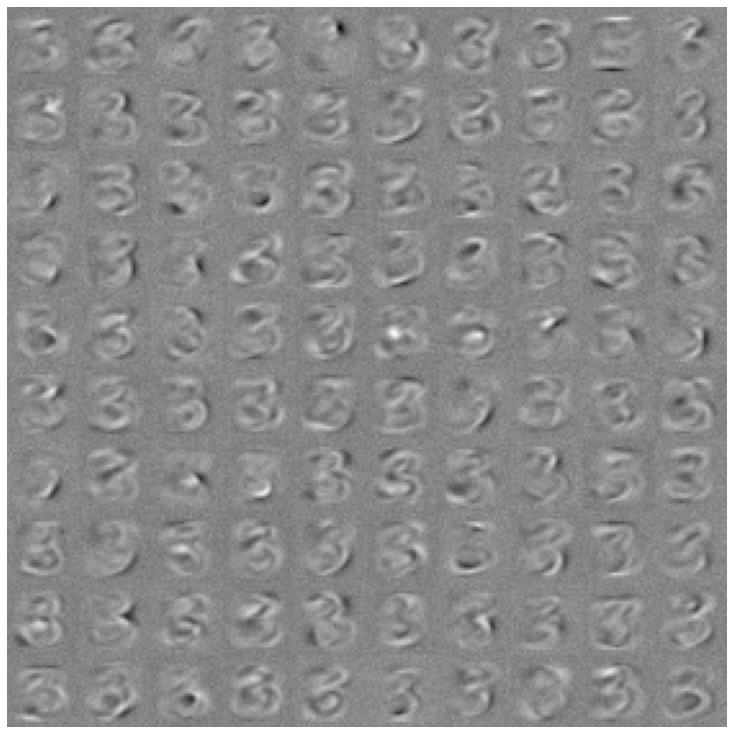

In [34]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
plt.imshow(rbm['W'].reshape(28,28,10,10).
           transpose(2,0,3,1).reshape(280,280),cmap='gray')


We observe that the RBM has learned a rich set of features, some of which are localized in pixel space, and therefore, apply to a large region of the input space. These features are statistically robust and also transferrable to other digits.